In [1]:
library(Seurat)
library(dplyr)
library(reticulate)
library(Matrix)
library(stringr)
library(readr)
library(harmony)
library(reshape2)
library(ggplot2)
library(repr)
library(cowplot)
library(ggpubr)
theme_set(theme_cowplot())
options(repr.plot.width=10, repr.plot.height=10)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend






***Generate full object***



In [2]:
setwd('/home/jovyan/data/covid_nasal/seurat_format/')
data<-readMM('nasal_counts.mtx')

genes<-read.csv('nasal_genes.csv', row.names = 1)

rownames(genes)<-gsub("GRCh38_", "", rownames(genes))
rownames(data)<-rownames(genes)

cells<-read.csv('nasal_cell_names.csv')
colnames(data)<-cells$index

In [3]:
covid<-CreateSeuratObject(counts = data, min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [4]:
setwd('/home/jovyan/data/covid_nasal/seurat_format/')
meta<-read.csv('nasal_metadata.csv', row.names = 1)

In [5]:
covid <- AddMetaData(covid, meta)

In [6]:
setwd('/home/jovyan/data/covid_nasal/stats')
doublets<-read.csv('doublets_score_mad_nasal_cellbender.csv', row.names = 1)
rownames(doublets)<-gsub("-", "_", rownames(doublets))

In [7]:
covid <- AddMetaData(covid, doublets)

In [9]:
covid<-subset(covid, subset = mad_prd == "False")

In [10]:
covid[["percent.mt"]] <- PercentageFeatureSet(covid, pattern = "^MT-")

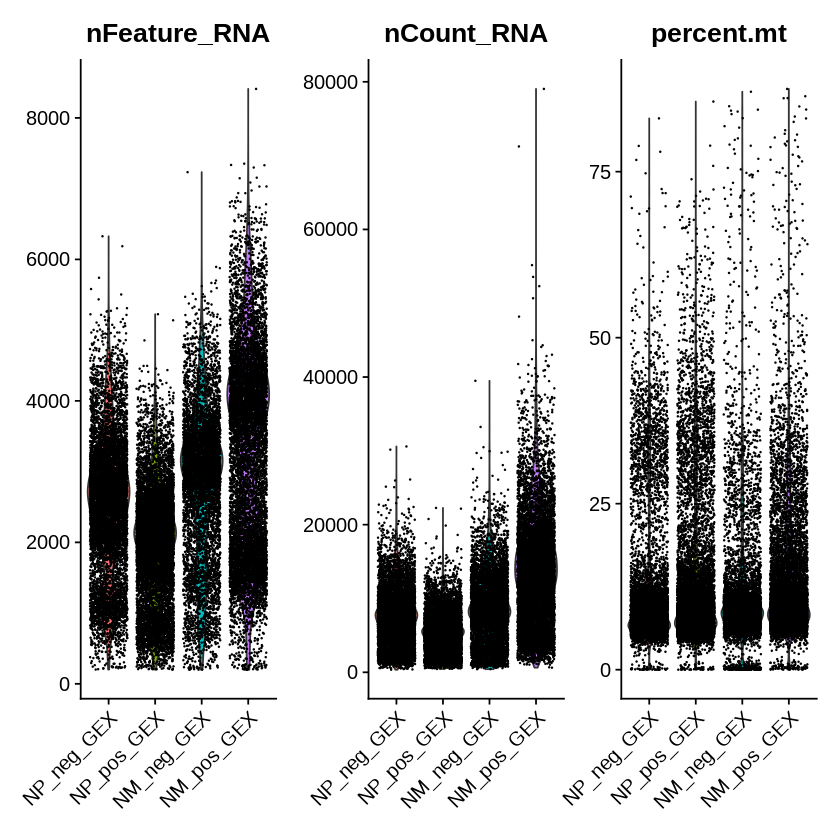

In [12]:
options(repr.plot.width=7, repr.plot.height=7)
Idents(covid)<-'sample_id'
VlnPlot(covid, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3) & theme(axis.title.x = element_blank())

setwd('/home/jovyan/data/covid_nasal/figures/')

ggsave("QC_by_sample.png", plot = last_plot(), device = NULL, path = NULL,width = 7, height = 7,  scale = 1)

In [101]:
covid <- subset(covid, subset = nFeature_RNA > 200 & nFeature_RNA < 7500 & percent.mt < 20)

In [103]:
setwd('/home/jovyan/data/covid_nasal/datasets')
saveRDS(covid, "covid_build_May2021.RDS")



***Untreated data***



In [4]:
setwd('/home/jovyan/data/covid_nasal/datasets')
covid<-readRDS("covid_build_May2021.RDS")

In [104]:
Idents(covid)<-"Treatment"
covid_US<-subset(covid, id = "Neg")

In [105]:
covid_US <- NormalizeData(covid_US)
covid_US <- FindVariableFeatures(covid_US, selection.method = "vst", nfeatures = 2000)
covid_US <- ScaleData(covid_US, verbose = FALSE)
covid_US <- RunPCA(covid_US, pc.genes = covid@var.genes, npcs = 20, verbose = FALSE)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


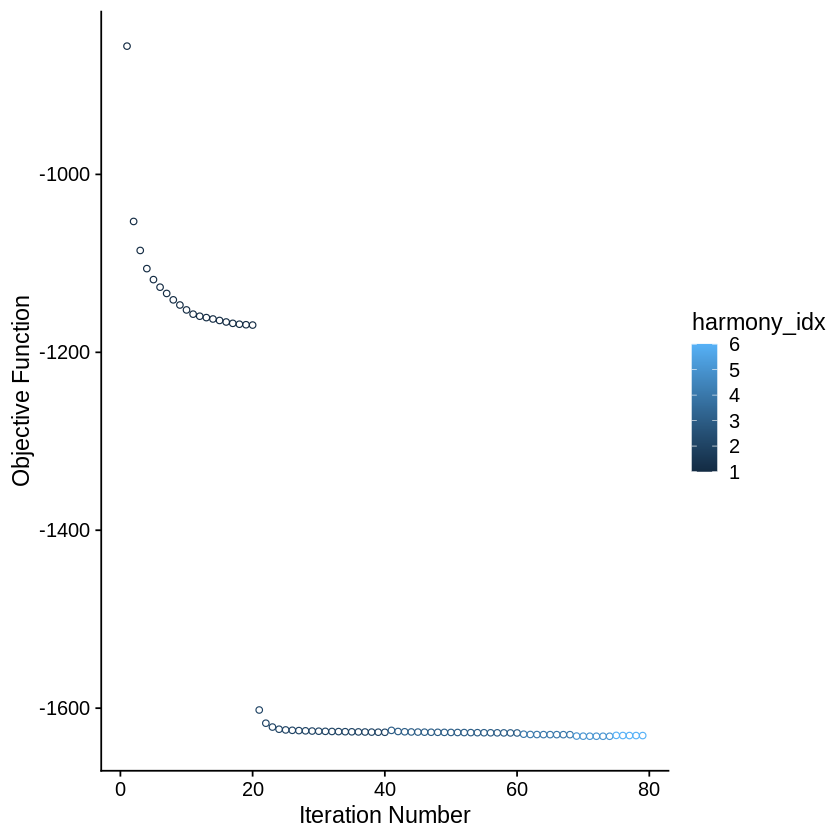

In [106]:
covid_US <- covid_US %>%  RunHarmony("Run", plot_convergence = TRUE)

In [107]:
covid_US <- covid_US %>% 
    RunUMAP(reduction = "harmony", dims = 1:20) %>% 
    FindNeighbors(reduction = "harmony", dims = 1:20) %>% 
    FindClusters(resolution = 0.5) %>% 
    identity()

09:16:03 UMAP embedding parameters a = 0.9922 b = 1.112

09:16:03 Read 12673 rows and found 20 numeric columns

09:16:03 Using Annoy for neighbor search, n_neighbors = 30

09:16:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:16:05 Writing NN index file to temp file /tmp/RtmpUpI7Oi/filec18628378e2c

09:16:05 Searching Annoy index using 1 thread, search_k = 3000

09:16:09 Annoy recall = 100%

09:16:09 Commencing smooth kNN distance calibration using 1 thread

09:16:10 Initializing from normalized Laplacian + noise

09:16:11 Commencing optimization for 200 epochs, with 534466 positive edges

09:16:17 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12673
Number of edges: 452152

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9005
Number of communities: 16
Elapsed time: 1 seconds


In [108]:
markers<-FindAllMarkers(covid_US, only.pos= TRUE, min.pct = 0.25, log.fc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [109]:
setwd('/home/jovyan/data/covid_nasal/stats')
write.csv(markers, "covid_US_markers_May2021.csv")

In [1]:
options(repr.plot.width=7, repr.plot.height=7)
Idents(covid_US)<-"seurat_clusters"
DimPlot(covid_US, reduction = "umap", label = TRUE, repel = TRUE)

ERROR: Error in Idents(covid_US) <- "seurat_clusters": object 'covid_US' not found


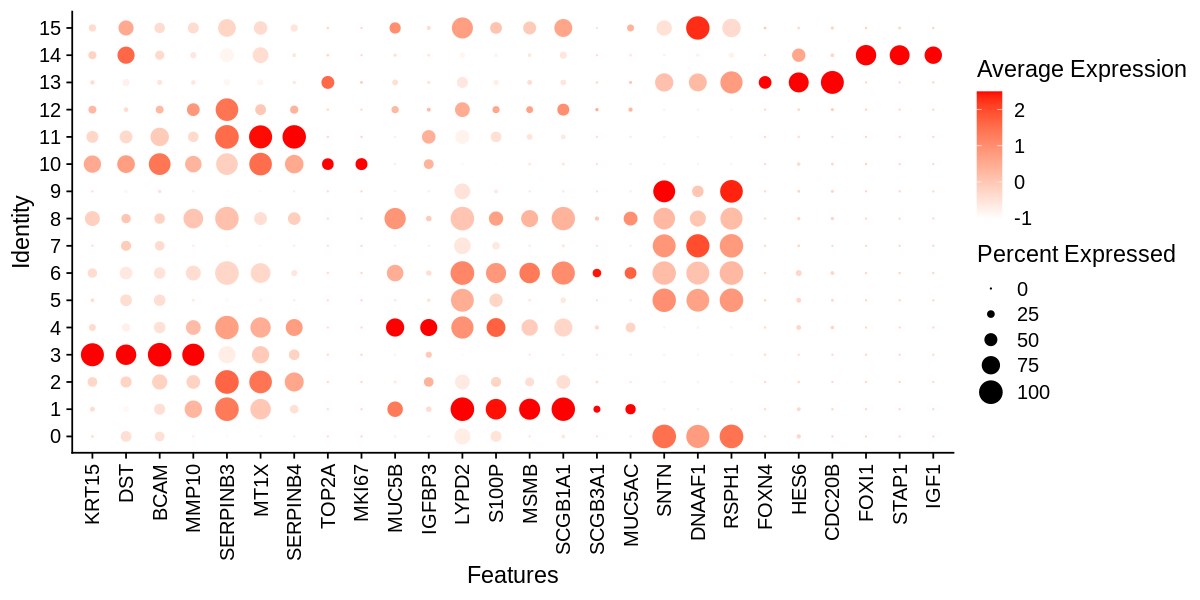

In [112]:
options(repr.plot.width=10, repr.plot.height=5)
Idents(covid_US)<-"seurat_clusters"
nasal_markers<-c("KRT15", "DST", "BCAM", "MMP10",   #basal 1
                 "SERPINB3", "MT1X", "SERPINB4",  #basal2
                 "TOP2A", "MKI67", #prolif
                 "MUC5B", "IGFBP3", "LYPD2", "S100P", "MSMB", "SCGB1A1", "SCGB3A1",  "MUC5AC", #secretory
                 "SNTN", "DNAAF1", "RSPH1",   #ciliated
                 "FOXN4", "HES6", "CDC20B",    #FOXN4
                 "FOXI1", "STAP1", "IGF1")     #Ionocyte


DotPlot(covid_US, features = nasal_markers, cols = c("white", "red"))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

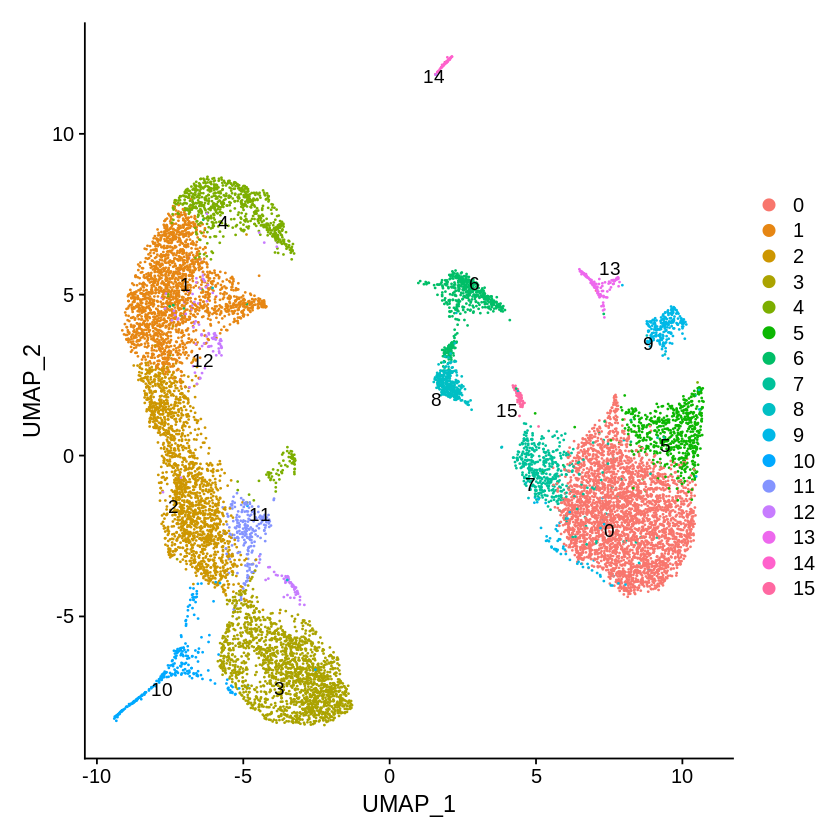

In [5]:
options(repr.plot.width=7, repr.plot.height=7)
Idents(covid_US)<-"seurat_clusters"
DimPlot(covid_US, reduction = "umap", label = TRUE, repel = TRUE)

In [6]:
Idents(covid_US)<-"seurat_clusters"
new.cluster.ids <- c("Ciliated", "Goblet", "Basal2", "Basal1", "Secretory", "Ciliated",
                    "Ciliated", "Ciliated", "Ciliated", "Ciliated", "Basal_prolif",
                    "Basal2", "Secretory", "Deuterosomal", "Ionocyte", "Ciliated")
                    
names(new.cluster.ids) <- levels(covid_US)
covid_US <- RenameIdents(covid_US, new.cluster.ids)
covid_US[["initial_clustering"]] <- Idents(covid_US)

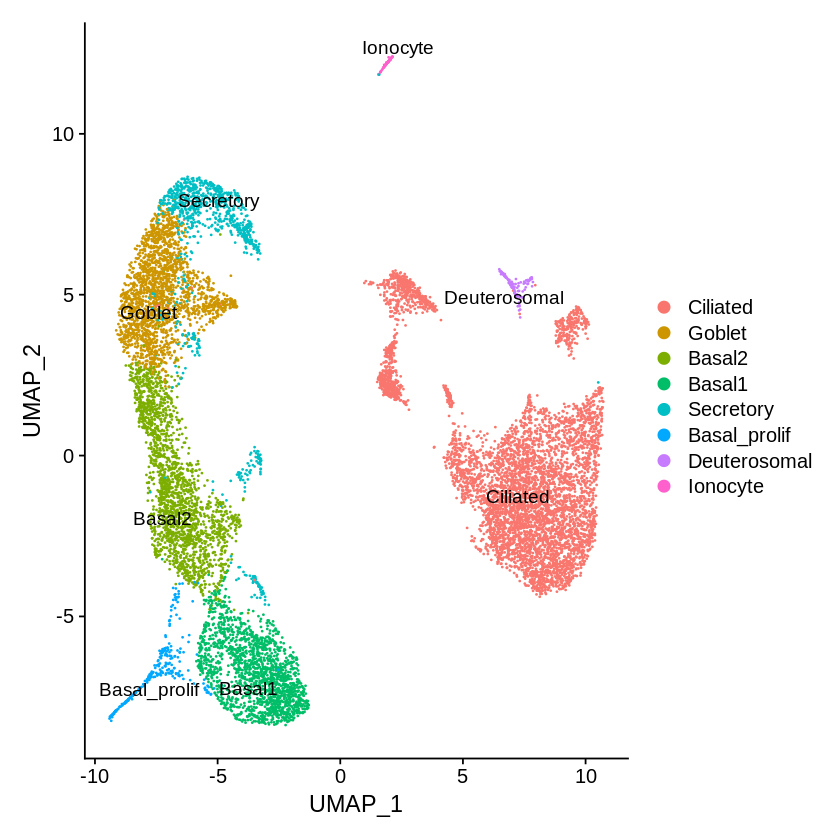

In [7]:
options(repr.plot.width=7, repr.plot.height=7)
Idents(covid_US)<-"initial_clustering"
DimPlot(covid_US, reduction = "umap", label = TRUE, repel = TRUE)

In [10]:
covid_US@meta.data$initial_clustering <- factor(covid_US@meta.data$initial_clustering, 
                                              levels = rev(c("Basal1", "Basal2", "Basal_prolif",
                                                             
                                                             "Secretory","Goblet", "Ciliated",
                                                             "Deuterosomal", "Ionocyte")))

In [ ]:
options(repr.plot.width=10, repr.plot.height=4)
Idents(covid_US)<-"initial_clustering"
nasal_markers<-c("KRT15", "DST", "BCAM", "MMP10",   #basal 1
                 "SERPINB3", "MT1X", "SERPINB4",  #basal2
                 "TOP2A", "MKI67", #prolif
                 "MUC5B", "IGFBP3", "LYPD2", "S100P",
                 "MSMB", "SCGB1A1", "SCGB3A1",  "MUC5AC", #club
                 "SNTN", "DNAAF1", "RSPH1",   #ciliated
                 "FOXN4", "HES6", "CDC20B",
                 "FOXI1", "STAP1", "IGF1")


DotPlot(covid_US, features = nasal_markers, cols = c("white", "red"))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

setwd('/home/jovyan/data/covid_nasal/figures')

ggsave("initial_clustering_dotplot.png", plot = last_plot(), device = NULL, path = NULL,width = 10, height = 4,  scale = 1)


In [17]:
setwd('/home/jovyan/data/covid_nasal/datasets')
saveRDS(covid_US, "covid_US.RDS")



***External dataset 4***
#https://www.biorxiv.org/content/10.1101/2021.02.20.431155v1


In [68]:
setwd('/home/jovyan/data/covid_nasal/datasets')
covid_US <- readRDS("covid_US.RDS")

In [18]:
setwd('/home/jovyan/data/covid_nasal/external_datasets/ziegler/SCP1289/expression')
raw_counts<-read.table("20210220_NasalSwab_RawCounts.txt",sep="\t")

In [19]:
ziegler<-CreateSeuratObject(raw_counts)

In [20]:
setwd('/home/jovyan/data/covid_nasal/external_datasets/ziegler/SCP1289/metadata')
meta<-read.table("20210220_NasalSwab_MetaData.txt", sep="\t", row.names = 1, header = TRUE)

In [21]:
ziegler<-AddMetaData(ziegler, meta)

In [22]:
ziegler[["percent.mt"]] <- PercentageFeatureSet(ziegler, pattern = "^MT-")

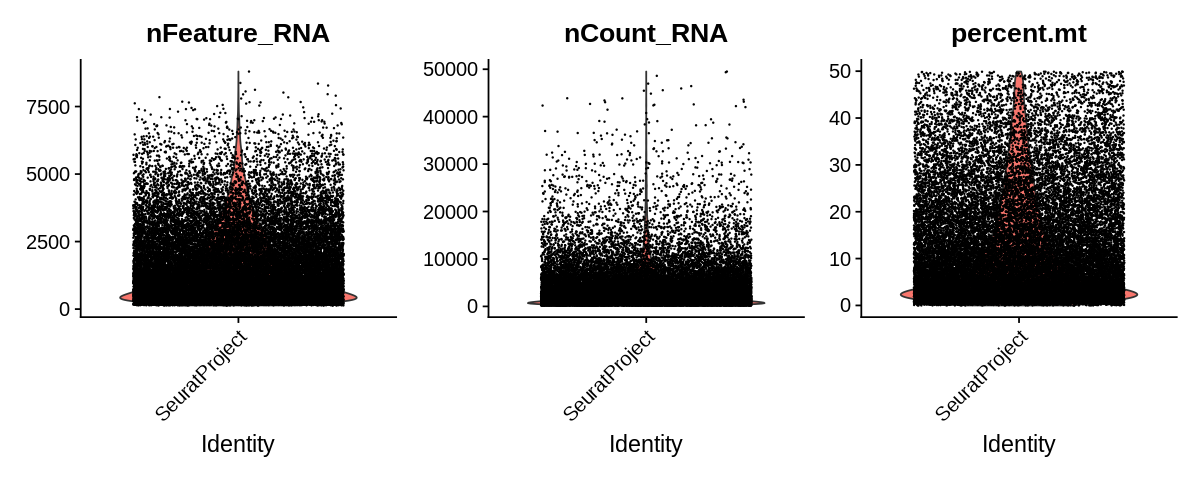

In [23]:
VlnPlot(ziegler, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [24]:
ziegler <- subset(ziegler, subset = nFeature_RNA > 200 & percent.mt < 20)

In [25]:
ziegler <- NormalizeData(ziegler)
ziegler <- FindVariableFeatures(ziegler, selection.method = "vst", nfeatures = 3000)

In [26]:
ziegler <- ScaleData(ziegler)
ziegler <- RunPCA(ziegler, features = VariableFeatures(object = ziegler))
ziegler <- FindNeighbors(ziegler, dims = 1:10)
ziegler <- RunUMAP(ziegler, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  RSPH1, TPPP3, C20orf85, AL357093.2, TMEM190, AC007906.2, FAM216B, TUBA1A, LDLRAD1, ZMYND10 
	   RRAD, IGFBP7, BEST4, CROCC2, CCDC113, OMG, MAP1A, TNFAIP8L1, FRMPD2, ECT2L 
	   FOXJ1, TCTEX1D4, C9orf116, CES1, TBC1D8, CCDC81, MAP6, AGR3, STOML3, SAMD15 
Negative:  CEACAM5, CEACAM6, NCCRP1, SCEL, EMP1, SPRR3, PRSS8, SPNS2, HSPB8, MAL 
	   GPRC5A, TMPRSS11E, LCN2, KRT13, PRSS27, TMPRSS11D, GCNT3, FAM129B, SPINT1, IL1RN 
	   CEACAM1, S100A9, FAM83A, KRT78, TMBIM1, KRT23, PPL, HOPX, ECM1, TMPRSS11B 
PC_ 2 
Positive:  TPPP3, RSPH1, C20orf85, AC007906.2, FAM216B, ZMYND10, TMEM190, LDLRAD1, AL357093.2, CCDC80 
	   SLPI, PSCA, PIGR, RRAD, ALDH3A1, CCDC113, AGR2, IGFBP7, CES1, C9orf116 
	   GOLM1, ADH7, STOML3, FOXJ1, MAP6, OMG, TNFAIP8L1, TACSTD2, WFDC2, IGFBP2 
Negative:  SRGN, LCP1, LAPTM5, PTPRC, VIM, TNFRSF1B, TYROBP, PLEK, ZEB2, CD83 
	   CD53, FCER1G, LGALS1, CCL3, LCP2, FLNA, CD44, SERPINB9, CCL4, FYB1 
	   BCL2A1, ITGB2, AIF1, SAMSN1,

In [27]:
anchors <- FindTransferAnchors(reference = ziegler, query = covid_US,
    dims = 1:30)
predictions <- TransferData(anchorset = anchors, refdata = ziegler$Coarse_Cell_Annotations,
    dims = 1:30)
covid_US <- AddMetaData(covid_US, metadata = predictions)
covid_US@meta.data$Ziegler<-covid_US@meta.data$predicted.id

Performing PCA on the provided reference using 2446 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 4057 anchors

Filtering anchors

	Retained 1433 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



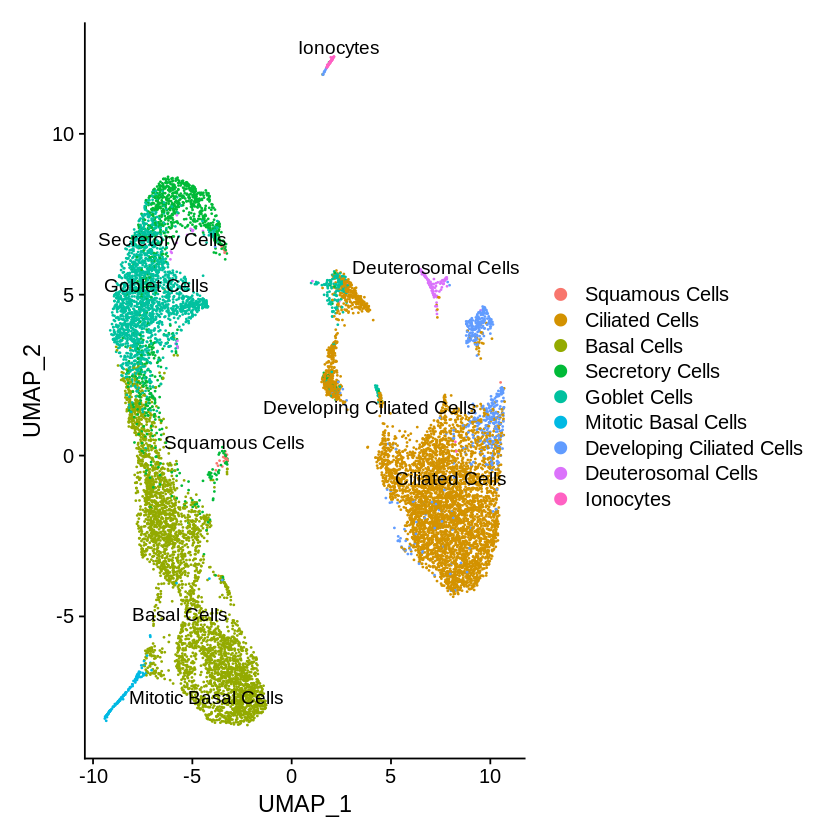

In [28]:
options(repr.plot.width=7, repr.plot.height=7)
Idents(covid_US)<-"Ziegler"
DimPlot(covid_US, reduction = "umap", label = TRUE, repel = TRUE)



***Ziegler props for full dataset***



In [114]:
#imported from second workbook

setwd('/home/jovyan/data/covid_nasal/datasets')
covid <- readRDS("covid_integrated.RDS")

In [125]:
covid@meta.data<-covid@meta.data %>% select(orig.ident, nCount_RNA, nFeature_RNA, sample_id, batch, Name, Treatment, 
                 Run, ds, thr, mad_MED, mad_MAD, mad_thr, auto_prd, mad_prd, percent.mt, 
                 RNA_snn_res.0.5, seurat_clusters, initial_clustering, initial_clustering_transfer)




In [ ]:
##Build datasets

In [2]:
setwd('/home/jovyan/data/covid_nasal/external_datasets/ziegler/SCP1289/expression')
raw_counts<-read.table("20210220_NasalSwab_RawCounts.txt",sep="\t")

In [3]:
ziegler<-CreateSeuratObject(raw_counts)

In [4]:
setwd('/home/jovyan/data/covid_nasal/external_datasets/ziegler/SCP1289/metadata')
meta<-read.table("20210220_NasalSwab_MetaData.txt", sep="\t", row.names = 1, header = TRUE)

In [5]:
ziegler<-AddMetaData(ziegler, meta)

In [6]:
ziegler[["percent.mt"]] <- PercentageFeatureSet(ziegler, pattern = "^MT-")

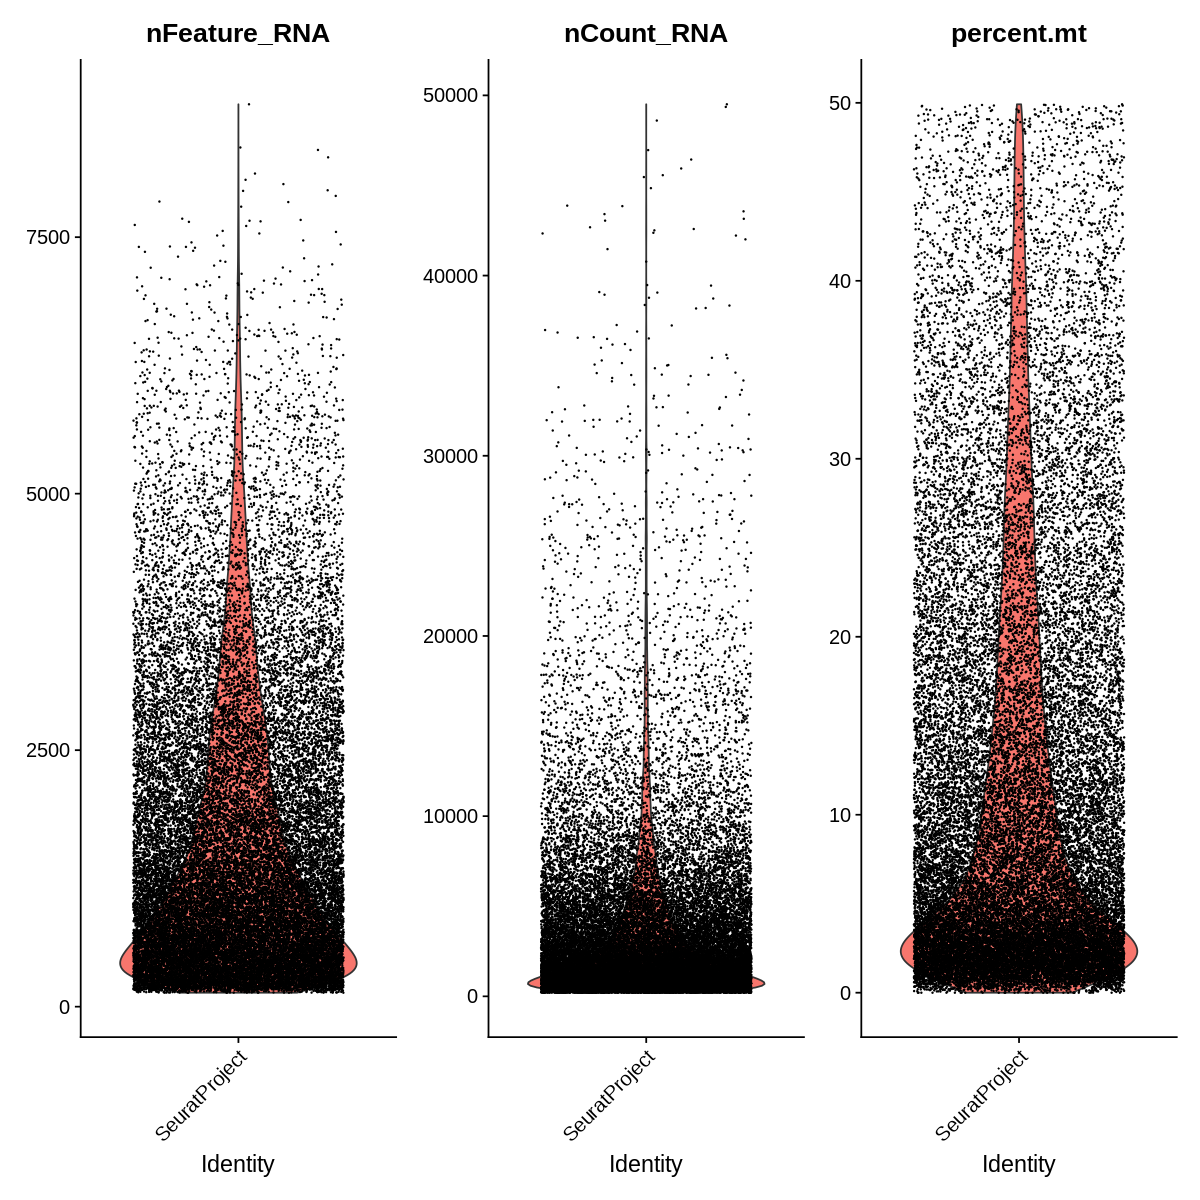

In [7]:
VlnPlot(ziegler, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [8]:
ziegler <- subset(ziegler, subset = nFeature_RNA > 200 & percent.mt < 20)

In [9]:
ziegler <- NormalizeData(ziegler)
ziegler <- FindVariableFeatures(ziegler, selection.method = "vst", nfeatures = 3000)

In [10]:
ziegler <- ScaleData(ziegler)
ziegler <- RunPCA(ziegler, features = VariableFeatures(object = ziegler))
ziegler <- FindNeighbors(ziegler, dims = 1:10)
ziegler <- RunUMAP(ziegler, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  RSPH1, TPPP3, C20orf85, AL357093.2, TMEM190, AC007906.2, FAM216B, TUBA1A, LDLRAD1, ZMYND10 
	   RRAD, IGFBP7, BEST4, CROCC2, CCDC113, OMG, MAP1A, TNFAIP8L1, FRMPD2, ECT2L 
	   FOXJ1, TCTEX1D4, C9orf116, CES1, TBC1D8, CCDC81, MAP6, AGR3, STOML3, SAMD15 
Negative:  CEACAM5, CEACAM6, NCCRP1, SCEL, EMP1, SPRR3, PRSS8, SPNS2, HSPB8, MAL 
	   GPRC5A, TMPRSS11E, LCN2, KRT13, PRSS27, TMPRSS11D, GCNT3, FAM129B, SPINT1, IL1RN 
	   CEACAM1, S100A9, FAM83A, KRT78, TMBIM1, KRT23, PPL, HOPX, ECM1, TMPRSS11B 
PC_ 2 
Positive:  TPPP3, RSPH1, C20orf85, AC007906.2, FAM216B, ZMYND10, TMEM190, LDLRAD1, AL357093.2, CCDC80 
	   SLPI, PSCA, PIGR, RRAD, ALDH3A1, CCDC113, AGR2, IGFBP7, CES1, C9orf116 
	   GOLM1, ADH7, STOML3, FOXJ1, MAP6, OMG, TNFAIP8L1, TACSTD2, WFDC2, IGFBP2 
Negative:  SRGN, LCP1, LAPTM5, PTPRC, VIM, TNFRSF1B, TYROBP, PLEK, ZEB2, CD83 
	   CD53, FCER1G, LGALS1, CCL3, LCP2, FLNA, CD44, SERPINB9, CCL4, FYB1 
	   BCL2A1, ITGB2, AIF1, SAMSN1,

In [15]:
setwd('/home/jovyan/data/covid_nasal/external_datasets/ziegler/')
saveRDS(ziegler, 'ziegler.RDS')

In [27]:
anchors <- FindTransferAnchors(reference = ziegler, query = covid,
    dims = 1:30)
predictions <- TransferData(anchorset = anchors, refdata = ziegler$Coarse_Cell_Annotations,
    dims = 1:30)
covid <- AddMetaData(covid, metadata = predictions)
covid@meta.data$Ziegler<-covid@meta.data$predicted.id

Performing PCA on the provided reference using 2446 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 6891 anchors

Filtering anchors

	Retained 1955 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [30]:
Ziegler_props<-dplyr::select(covid@meta.data, initial_clustering,
                            prediction.score.Developing.Ciliated.Cells,
                             prediction.score.Ciliated.Cells,
                             prediction.score.Secretory.Cells,
                             prediction.score.Squamous.Cells,
                             prediction.score.Goblet.Cells,
                             prediction.score.Basal.Cells,
                             prediction.score.Deuterosomal.Cells,
                             prediction.score.Mitotic.Basal.Cells,
                             prediction.score.Developing.Secretory.and.Goblet.Cells,
                             prediction.score.Ionocytes)

In [31]:
Ziegler_data<-aggregate(.~initial_clustering,data=Ziegler_props,FUN=median)
colnames(Ziegler_data)<-c("initial_clustering", "Developing_ciliated", "Ciliated", "Secretory", 
                        "Squamous", "Goblet", "Basal", "Deuterosomal", "Basal_mitotic",
                         "Developing_secretory_goblet", "Ionocytes")
Ziegler_data<-melt(Ziegler_data, id = c("initial_clustering"))
colnames(Ziegler_data)<-c('our_annotation', 'ziegler_annotation', 'correlation')

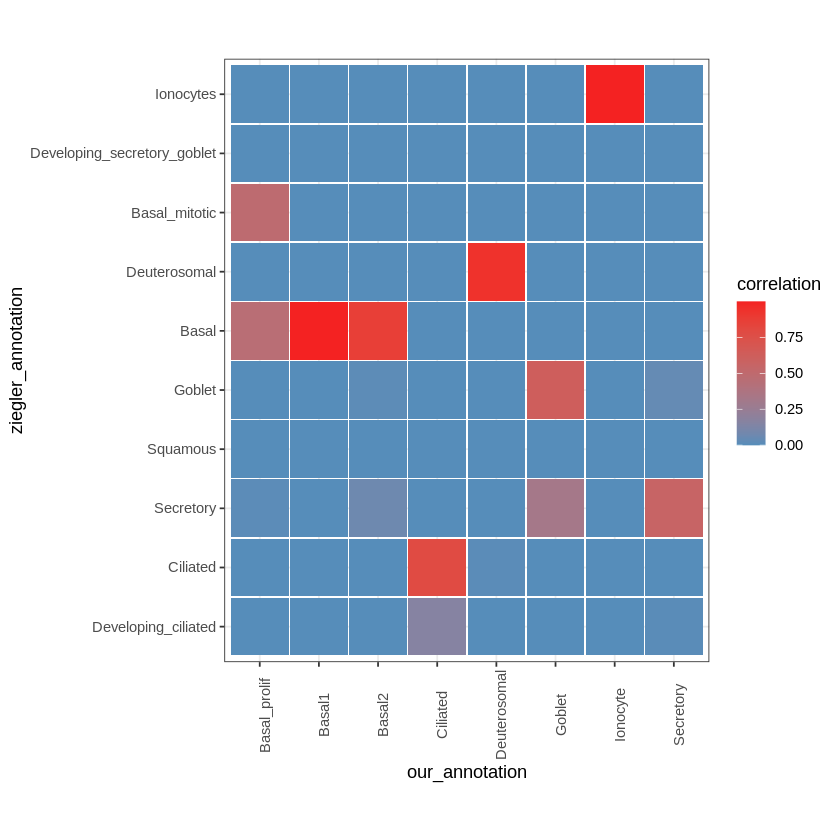

In [132]:
ggplot(data = Ziegler_data, mapping = aes(x = our_annotation, y = ziegler_annotation, fill = correlation)) + 
geom_tile(width=0.975, height=0.975) + theme_bw() + coord_equal() + theme(axis.text.x = element_text(angle = 90)) +
scale_fill_gradient(low = "#568dba", high = "#f42222")

In [32]:
Ziegler_data <- Ziegler_data[!(Ziegler_data$ziegler_annotation %in% c('Enteroendocrine', 'Developing_secretory_goblet',
                                                                   'Developing_ciliated')), ]

In [33]:
Ziegler_data$ziegler_annotation <- factor(Ziegler_data$ziegler_annotation, levels = rev(c("Basal",
                                                      "Basal_mitotic",                                
                                                      "Secretory",
                                                      "Goblet",
                                                      "Developing_secretory_goblet",
                                                      "Ciliated",
                                                      "Developing_ciliated",
                                                      "Squamous",
                                                      "Deuterosomal",
                                                      "Ionocytes")))

In [ ]:
Ziegler_data$our_annotation <- factor(Ziegler_data$our_annotation, 
                                              levels = c("Basal1", "Basal2", "Basal_prolif", 
                                                             "Secretory", "Goblet", "Ciliated",
                                                             "Deuterosomal", "Ionocyte"))



Ziegler_data$ziegler_annotation <- factor(Ziegler_data$ziegler_annotation, levels = rev(c("Basal",
                                                      "Basal_mitotic",                                
                                                      "Secretory",
                                                      "Goblet",
                                                      "Developing_secretory_goblet",
                                                      "Ciliated",
                                                      "Developing_ciliated",
                                                      "Squamous",
                                                      "Deuterosomal",
                                                      "Ionocytes")))

setwd('/home/jovyan/data/covid_nasal/figures')


ggplot(data = Ziegler_data, mapping = aes(x = our_annotation, y = ziegler_annotation, fill = correlation)) + 
geom_tile(width=0.975, height=0.975) + theme_bw() + coord_equal() + theme(axis.text.x = element_text(angle = 90)) +
scale_fill_gradient(low = "#568dba", high = "#f42222", na.value = '#568dba')+
theme(axis.text = element_text(size = 15)) + xlab('our_annotation') + ylab('external_annotation')


ggsave("dataset_alignment_full_dataset.png", plot = last_plot(), device = NULL, path = NULL,width = 7, height = 7,  scale = 1)

In [141]:
setwd('/home/jovyan/data/covid_nasal/datasets')
saveRDS(covid, "covid_integrated.RDS")

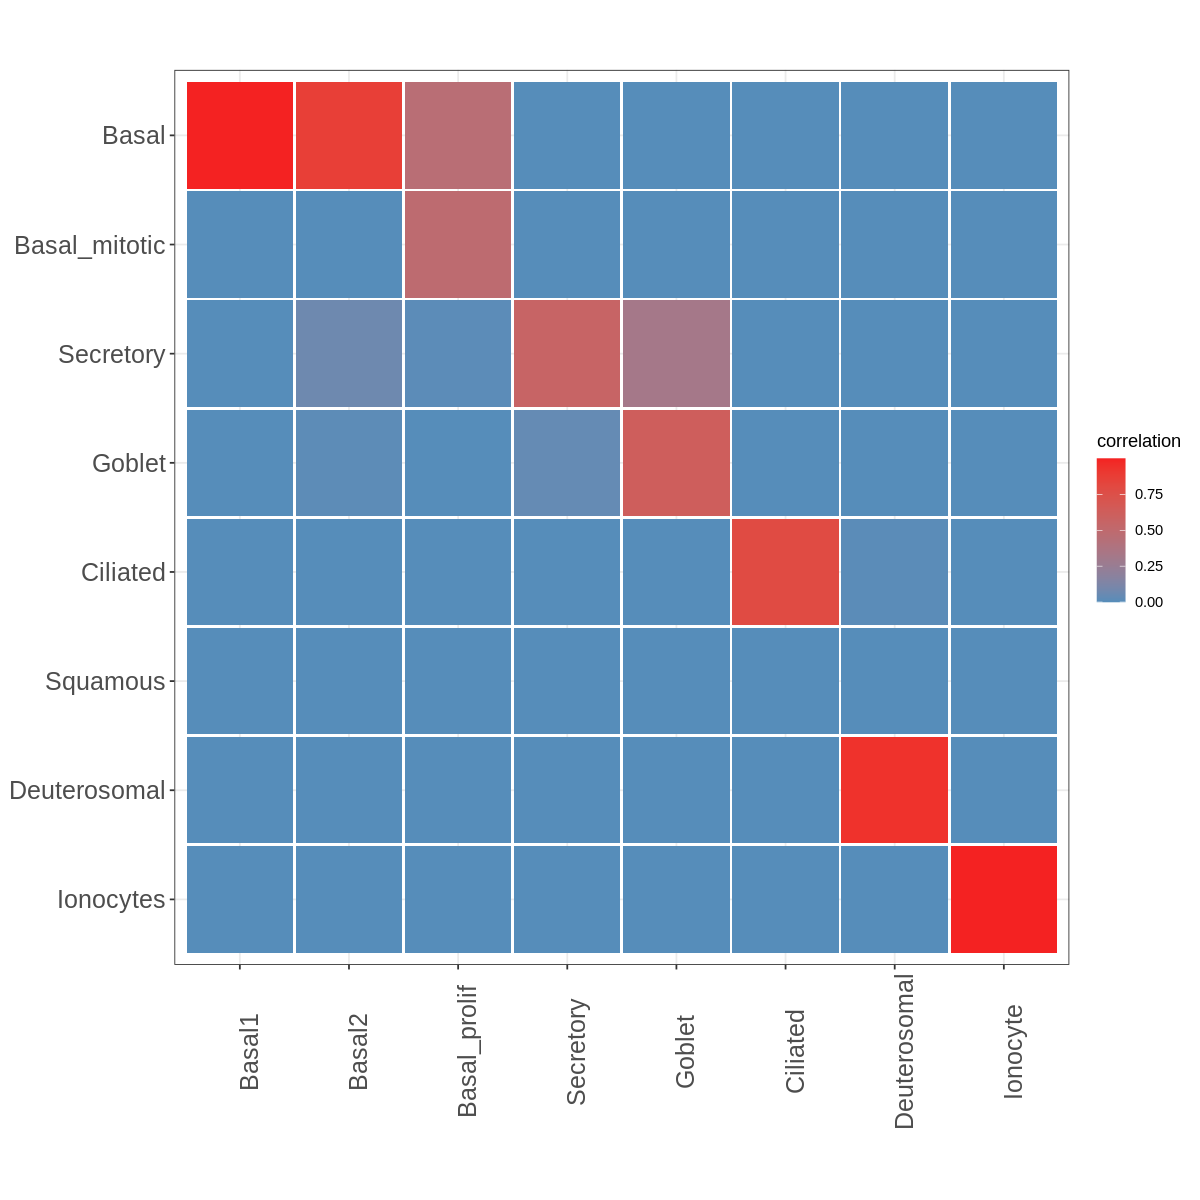

In [26]:
Ziegler_data$our_annotation <- factor(Ziegler_data$our_annotation, 
                                              levels = c("Basal1", "Basal2", "Basal_prolif", 
                                                             "Secretory", "Goblet", "Ciliated",
                                                             "Deuterosomal", "Ionocyte"))



Ziegler_data$ziegler_annotation <- factor(Ziegler_data$ziegler_annotation, levels = rev(c("Basal",
                                                      "Basal_mitotic",                                
                                                      "Secretory",
                                                      "Goblet",
                                                      "Developing_secretory_goblet",
                                                      "Ciliated",
                                                      "Developing_ciliated",
                                                      "Squamous",
                                                      "Deuterosomal",
                                                      "Ionocytes")))

setwd('/home/jovyan/data/covid_nasal/figures')


ggplot(data = Ziegler_data, mapping = aes(x = our_annotation, y = ziegler_annotation, fill = correlation)) + 
geom_tile(width=0.975, height=0.975) + theme_bw() + coord_equal() + theme(axis.text.x = element_text(angle = 90)) +
scale_fill_gradient(low = "#568dba", high = "#f42222", na.value = '#568dba')+
theme(axis.title = element_blank(),
     axis.text = element_text(size = 15))


ggsave("dataset_alignment_stimulated_only.png", plot = last_plot(), device = NULL, path = NULL,width = 7, height = 7,  scale = 1)